# Final Project - Approximating Effective Temperature of Stars from Photometric Parameters

For our final project, we decided to use photometric parameters of stars to regress on the effective temperature of the star. Effective temperature is a **spectroscopic** parameter and is therefore difficult to estimate empirically. But, effective temperature serves as a proxy for the age of the star, which is an important astronomical parameter when studying stellar evolution.

Due to temperature being associated with color, we decided to the photometric paramters for the stars (which are easier to empirically obtain) as the attributes for regressing the effective temperature of the star.

In this project, we try several different regression models and pick the highest performing model based on `RMSE`.

## Team Members
| Name | Section |
| :--: | :--:|
| Rik Ghosh | 50565 |
| Rodrigo Brandao | 50565 |
| Sidharth Srinivas | 50560 |
| Pranav Srinivasan | 50555 |

In [28]:
# Imports
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import pyarrow as pa
import scipy.stats as sts
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from tabulate import tabulate
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from matplotlib.colors import Normalize
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.kernel_approximation import Nystroem
from sklearn.utils._testing import ignore_warnings
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor as xgb

In [2]:
# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

## Reading Data and Initial Diagnositics

In this section, we focus on reading in the data and performing some initial diagnostics.

- Some of the columns in the data have integer values, but are meant to be treated as categories.
    - Therefore we change the data types accordingly.
- Each column likely contains some outliers and extreme values.
    - For numeric data, we plot histograms with all data points, and with extreme values removed (95% of data centered around the mean).
    - For categorical data, we plot bar plots to analyze the skewness and counts.
    - We also provide the summary table for each column in the data.
- We check for rows with missing data. We didn't have any such rows.
    - If we did, for numeric data, we would likely use mean-imputation.
    - For categorical data, we would likely drop the row.

In [3]:
# utility function to print the column names and data types for each column in a dataframe
def print_col_types(data: pd.DataFrame) -> None:
    print("\nCols\tData Type")
    print("----\t---------")
    print(data.dtypes)

In [4]:
# read the data and run diagnositics
data = pd.read_csv("skyserver_data.csv")
VIEW_ROWS = 5

print(f"Number of Rows: {data.shape[0]}, Number of Columns: {data.shape[1]}\n")

print(f"First {VIEW_ROWS} Rows")
display(data.head(VIEW_ROWS))
print(f"Last {VIEW_ROWS} Rows")
display(data.tail(VIEW_ROWS))

print_col_types(data)

Number of Rows: 347046, Number of Columns: 11

First 5 Rows


,u,g,r,i,z,type,mode,flags,feh,teff,logg
0,17.74149,16.59350,16.17159,16.02715,15.93656,6,1,nnnnn,-0.676982,5965.954,4.201272
1,18.99371,18.00112,17.63029,17.50343,17.44212,6,1,nnnnn,-1.313370,5944.153,3.599674
2,17.76598,16.86959,16.54257,16.41686,16.37806,6,1,nnnnn,-1.872914,6328.010,3.970203
3,18.53829,17.55103,17.06516,16.85526,16.74448,6,1,nnnnn,-1.804460,6132.964,3.968426
4,18.95163,17.89401,17.47597,17.31722,17.23473,6,1,nnnnn,-0.957447,5857.972,3.939497


Last 5 Rows


,u,g,r,i,z,type,mode,flags,feh,teff,logg
347041,19.74876,17.92489,17.17177,16.85879,16.65431,6,1,nnBgn,-1.087301,4862.076,4.464107
347042,18.77587,17.12293,16.38808,16.06931,15.89801,6,1,nnnnn,-2.068112,4947.906,1.725994
347043,20.44156,17.98008,16.91404,16.52675,16.30901,6,1,nnnnn,-0.698523,4496.792,4.540200
347044,19.48390,18.31149,17.89681,17.71497,17.63102,6,1,nnnnn,-0.844079,5844.436,4.074500
347045,19.97392,18.33957,17.69984,17.46040,17.33603,6,1,nnnnn,-0.910552,5080.398,1.963508



Cols	Data Type
----	---------
u        float64
g        float64
r        float64
i        float64
z        float64
type       int64
mode       int64
flags     object
feh      float64
teff     float64
logg     float64
dtype: object


In [5]:
# some of the data types are actually class names, but represented as numbers. We will change them to categorical
data_typed = data.astype({'type': 'object', 'mode': 'object'})

print_col_types(data)       #before
print_col_types(data_typed) #after


Cols	Data Type
----	---------
u        float64
g        float64
r        float64
i        float64
z        float64
type       int64
mode       int64
flags     object
feh      float64
teff     float64
logg     float64
dtype: object

Cols	Data Type
----	---------
u        float64
g        float64
r        float64
i        float64
z        float64
type      object
mode      object
flags     object
feh      float64
teff     float64
logg     float64
dtype: object


In [6]:
# utility function to look at the distribution of values for columns
def explore_distribution(col_name: list[str], series: pd.Series, num_bins: int = 20, interval: float = .95) -> None:
    # numeric data
    if series.dtypes == "float64":
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(12, 5)
        fig.suptitle(f"Distribution of {col_name} with and without Extreme Values")

        axs[0].set_title("With Extreme Values")
        axs[0].hist(series, num_bins, label=col_name)
        axs[0].set_xlabel(col_name)
        axs[0].set_ylabel("count")

        # retain interval% of data and remove extreme values (outliers)
        tail = (1 - interval) / 2
        low_q = series.quantile(tail)
        high_q = series.quantile(1 - tail)
        s = series[(series >= low_q) & (series <= high_q)]

        axs[1].set_title("Without Extreme Values")
        axs[1].hist(s, num_bins, label=col_name)
        axs[1].set_xlabel(col_name)
        axs[1].set_ylabel("count")
        
        plt.show()

    # categorical data
    else:
        plt.title(f"Distribution of {col_name}")
        plt.bar([str(x) for x in series.unique()], series.value_counts())
        plt.xlabel(col_name)
        if len(plt.gca().get_xticks()) > 5:
            plt.xticks(rotation=90)
        plt.ylabel("count")
        plt.show()

In [7]:
# utility function to show diagnostic plots and summary details
def show_diagnostic_plots(cols: list[str], data: pd.DataFrame, plots_data: dict = None, plots_only: bool = False, summary_only: bool = False) -> None:
    if plots_only:
        summary_only = False
    elif summary_only:
        plots_only = False
    else:
        plots_only = True
        summary_only = True

    if plots_only:
        for col in cols:
            if (plots_data):
                explore_distribution(col, data[col], **plots_data)
            else:
                explore_distribution(col, data[col])

    if summary_only:
        for col in cols:
            print()
            print(f"DESCRIBING COLUMN {col}")
            print("-"*20)
            print(data[col].describe())
            print()

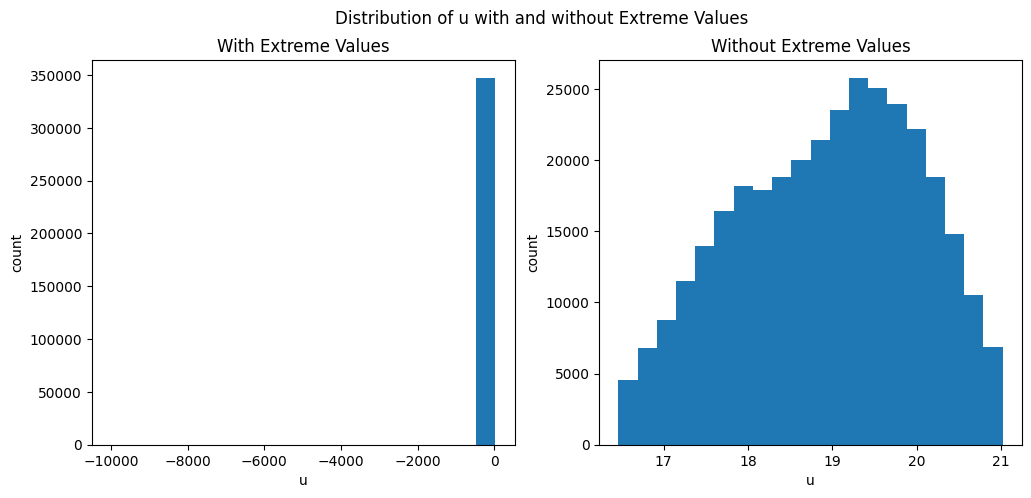

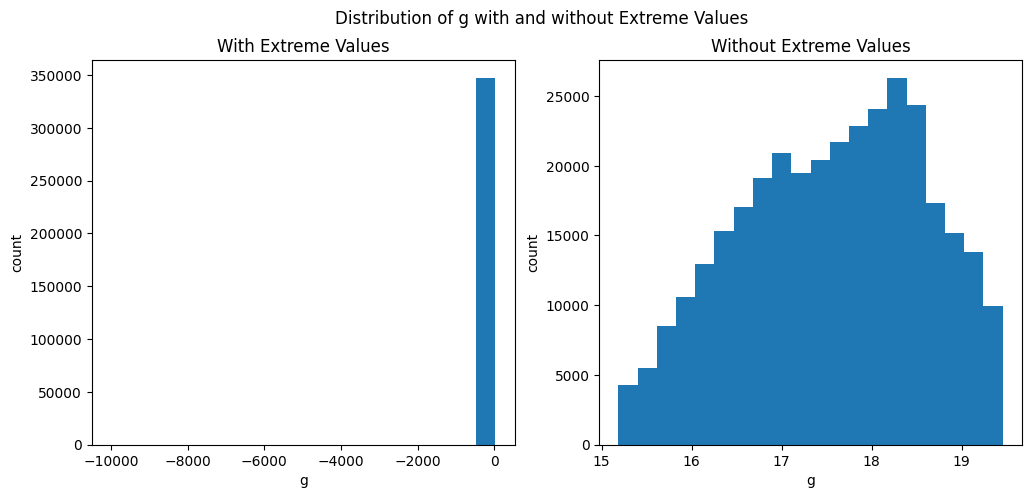

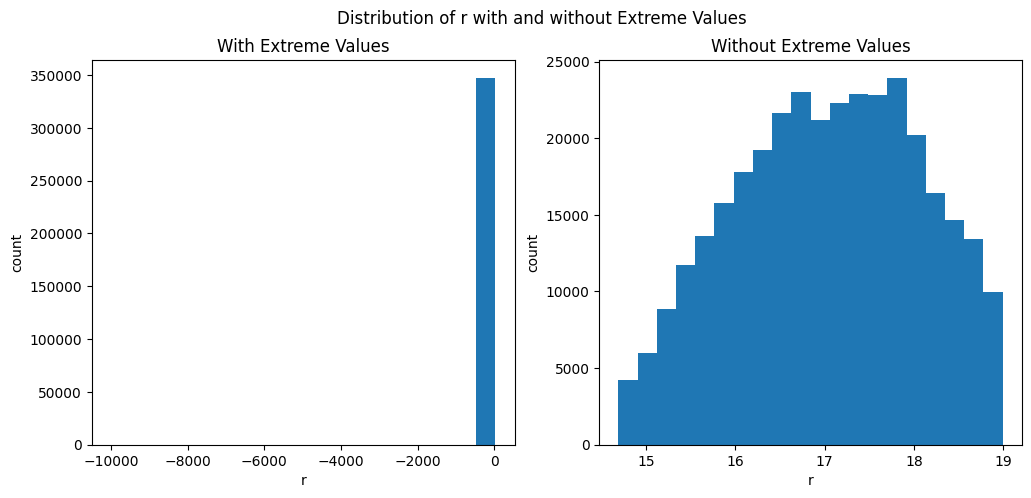

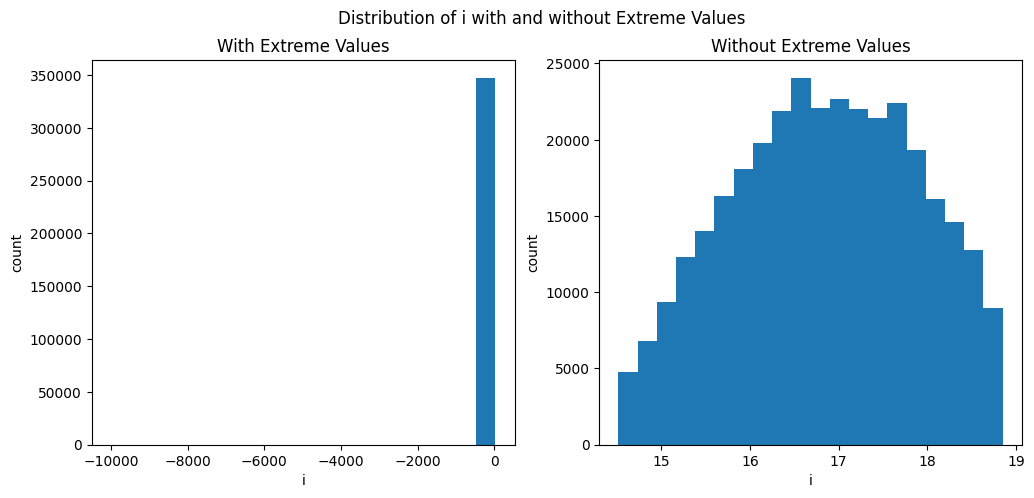

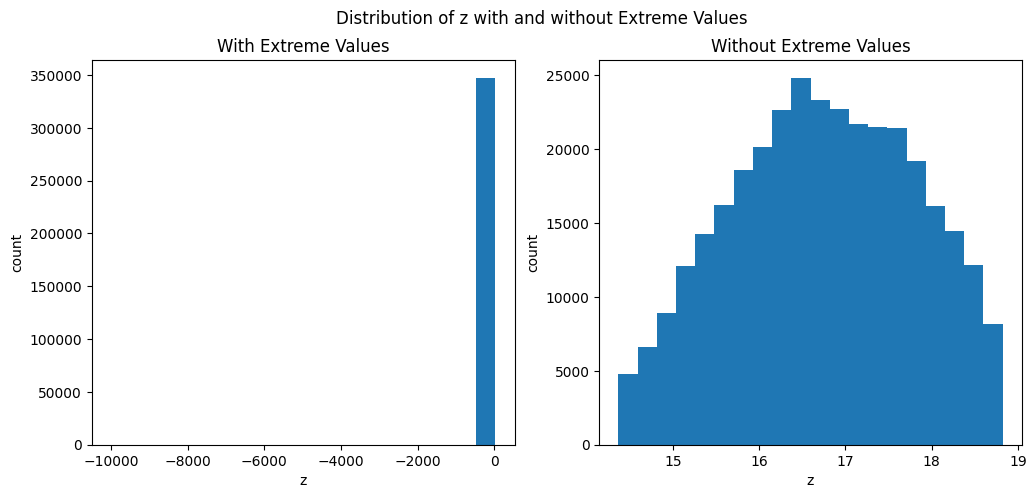

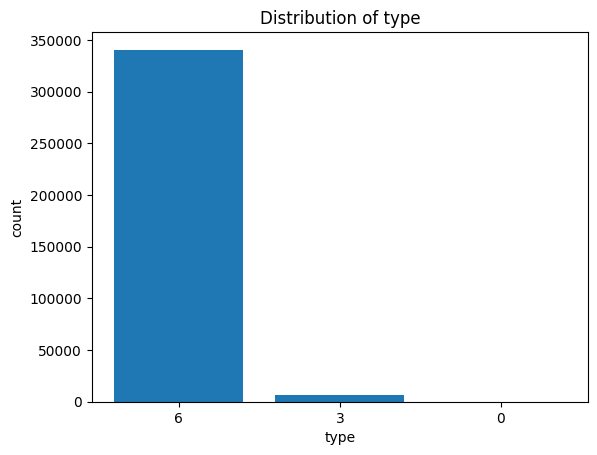

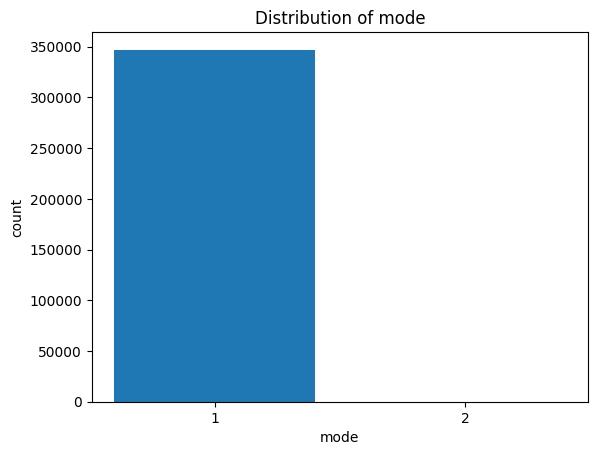

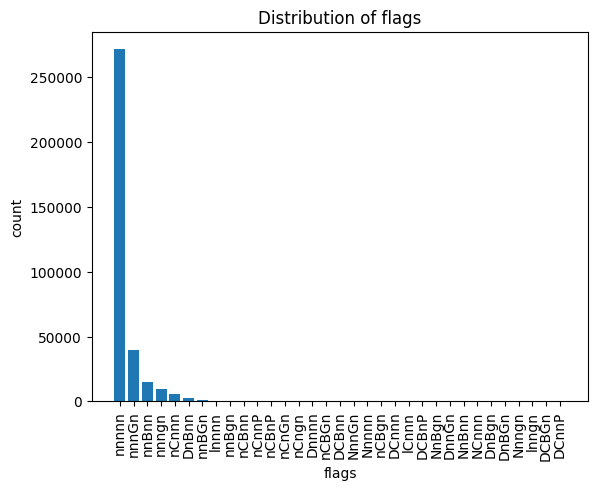

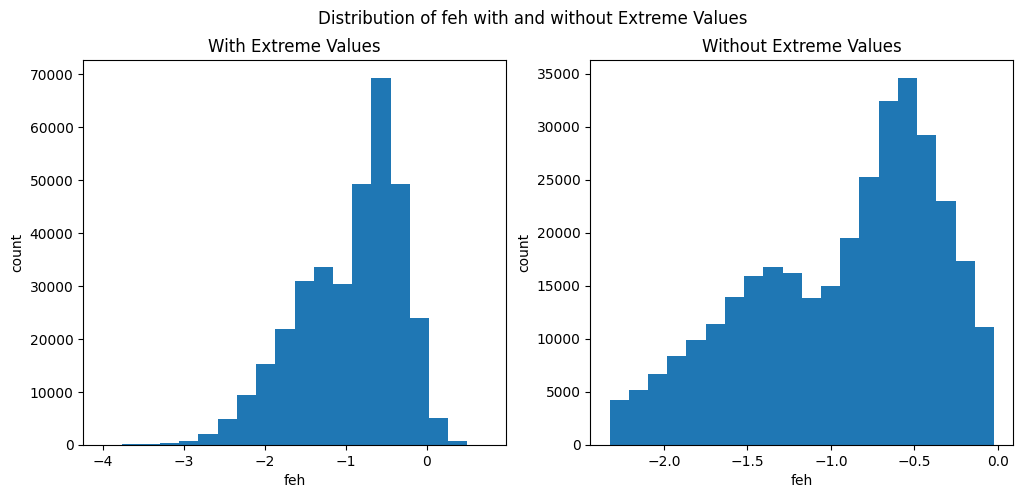

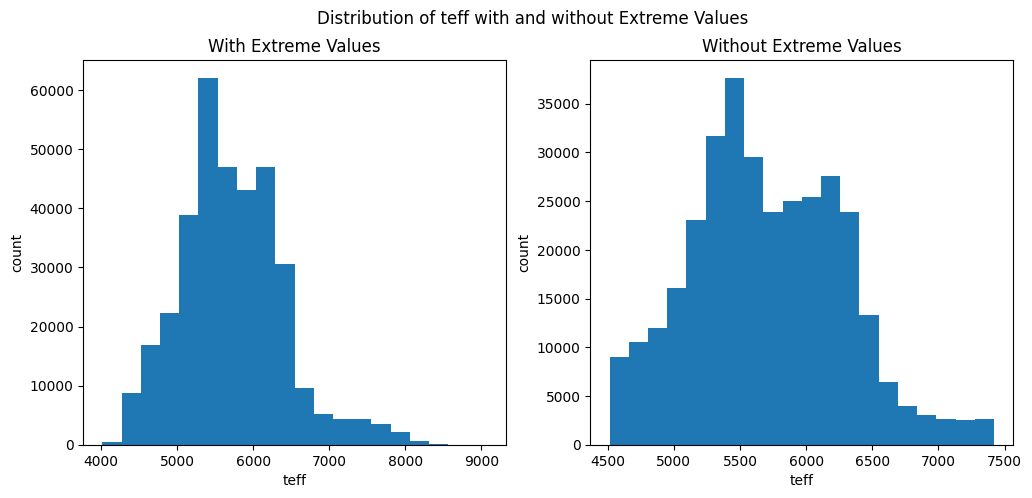

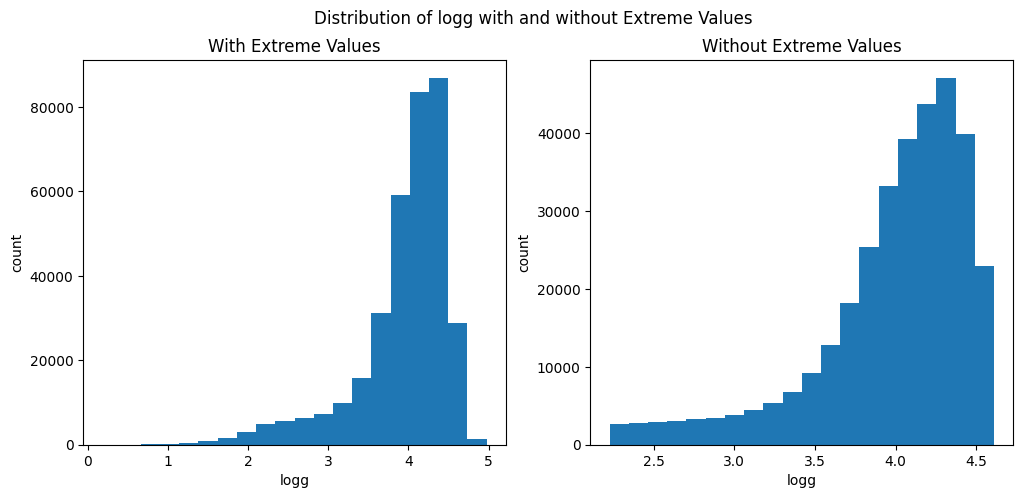


DESCRIBING COLUMN u
--------------------
count    347046.000000
mean         17.913983
std         100.607503
min       -9999.000000
25%          18.032990
50%          19.034985
75%          19.830920
max          30.169740
Name: u, dtype: float64


DESCRIBING COLUMN g
--------------------
count    347046.000000
mean         16.560493
std          99.145857
min       -9999.000000
25%          16.724328
50%          17.640905
75%          18.409045
max          31.284590
Name: g, dtype: float64


DESCRIBING COLUMN r
--------------------
count    347046.000000
mean         16.210533
std          89.971070
min       -9999.000000
25%          16.197682
50%          17.075785
75%          17.885848
max          31.406520
Name: r, dtype: float64


DESCRIBING COLUMN i
--------------------
count    347046.000000
mean         15.839269
std          99.138931
min       -9999.000000
25%          15.991612
50%          16.854195
75%          17.704440
max          31.468180
Name: i, dtype: float

In [8]:
# diagnositc plots
FEATURE_COLS = data_typed.columns.values 
    
show_diagnostic_plots(FEATURE_COLS, data_typed)

In [9]:
# check for any missing data
print(data_typed.isna().sum())

u        0
g        0
r        0
i        0
z        0
type     0
mode     0
flags    0
feh      0
teff     0
logg     0
dtype: int64


## Preprocessing and Feature Engineering

In this section, we focus on data cleaning and feature engineering.

Since our final project only focuses on stars with high quality data and normal flags, we want our dataset to only retains rows with
- `type == "6"` $~~~~~~~~~~~~~~~~~$ (Type `6` implies its a star) 
- `mode == "1"` $~~~~~~~~~~~~~~~~~$ (Mode `1` implies its a primary source or is high quality data)
- `flags == "nnnnn"` $~~~~~~~$ (Flags `nnnnn` implies that all flags are normal)

We also want to remove outliers from the color magnitudes.
- They are represented with the recode value of `-9999`. We just drop the rows with this recode.
- We also use anomaly detection algorithms (`Isolation Forest`, `Local Outlier Factor`) to identify anomolous data points. If all algorithms identify a row as being anomolous, we drop that row.

Lastly, we want to use the colors as our attributes for regression. A color in astronomy is defined as the difference of two photometric magnitudes. Therefore, we engineer the pairwise difference of all photometric magnitudes in our dataset.

In [10]:
# flag to display extra plots and summary
VIEW_INFO = False

In [11]:
print("Before Preprocessing")
print("====================")
print(f"Number of Rows: {data_typed.shape[0]}, Number of Columns: {data_typed.shape[1]}\n")

# only keep stars (type == 6) marked as primary (mode == 1) with normal SSPP flags (flags == nnnnn)
# remove the columns used for filtering
wanted_rows_data = data_typed[(data_typed["type"] == 6) & \
                              (data_typed["mode"] == 1) & \
                              (data_typed["flags"] == "nnnnn")].drop(["type", "mode", "flags"], axis=1)

print("After Removing Unwanted Rows")
print("============================")
print(f"Number of Rows: {wanted_rows_data.shape[0]}, Number of Columns: {wanted_rows_data.shape[1]}\n")

if (VIEW_INFO):
    show_diagnostic_plots(wanted_rows_data.columns.values, wanted_rows_data)

# remove outliers in the training attributes. The color filters use -9999 as a special recode.
# We want to remove these rows to prevent skewing our data

tmp = wanted_rows_data[(wanted_rows_data["u"] != -9999.0) & \
                       (wanted_rows_data["g"] != -9999.0) & \
                       (wanted_rows_data["r"] != -9999.0) & \
                       (wanted_rows_data["i"] != -9999.0) & \
                       (wanted_rows_data["z"] != -9999.0)]

# use anomaly detection algorithms to eliminate anomolous data points 
color_mags = tmp.columns.drop(["feh", "teff", "logg"])
Xs = tmp[color_mags]

contamination = 0.40

out1 = [x == 1 for x in IsolationForest(contamination=contamination).fit_predict(Xs)]
out2 = [x == 1 for x in LocalOutlierFactor(contamination=contamination).fit_predict(Xs)]

# drop data points that are identified as outliers by both algorithms
no_outliers_data = tmp[[a or b for a, b in zip(out1, out2)]]

if (VIEW_INFO):
    alg1_outcount = len(out1) - np.sum(out1)
    alg2_outcount = len(out2) - np.sum(out2)
    both_outcount = np.sum([not (a or b) for a, b in zip(out1, out2)])
    plt.bar(["Isolation Forest", "Local Outlier Factor", "Both"], [alg1_outcount, alg2_outcount, both_outcount])
    plt.xlabel("Algorithm")
    plt.ylabel("Number of Anomolous Points Identified")
    plt.title("Anomalous Datapoint Count")
    plt.show()

print("After Removing Outliers")
print("=======================")
print(f"Number of Rows: {no_outliers_data.shape[0]}, Number of Columns: {no_outliers_data.shape[1]}\n")

if (VIEW_INFO):
    show_diagnostic_plots(no_outliers_data.columns.values, no_outliers_data)

# it is more interesting to look at the pairwise color differences instead of the raw magnitudes
# we will engineer the new columns, and remove any redundant columns
complete_data = pd.DataFrame()

# Domain Knowledge: since these filters are arranged in decreasing order of energy, it doesn't make
# sense to consider every permutation, just the combinations
for i in range(len(color_mags)):
    for j in range(i + 1, len(color_mags)):
        high_mag = color_mags[i]
        low_mag = color_mags[j]
        complete_data[f"{high_mag}_{low_mag}"] = no_outliers_data[high_mag] - no_outliers_data[low_mag]

complete_data["feh"] = no_outliers_data["feh"]
complete_data["teff"] = no_outliers_data["teff"]
complete_data["logg"] = no_outliers_data["logg"]

print("After Engineering New Attributes")
print("================================")
print(f"Number of Rows: {complete_data.shape[0]}, Number of Columns: {complete_data.shape[1]}")

if (VIEW_INFO):
    show_diagnostic_plots(complete_data.columns.values, complete_data)

Before Preprocessing
Number of Rows: 347046, Number of Columns: 11

After Removing Unwanted Rows
Number of Rows: 267171, Number of Columns: 8

After Removing Outliers
Number of Rows: 222070, Number of Columns: 8

After Engineering New Attributes
Number of Rows: 222070, Number of Columns: 13


## Data Exploration

After engineering new features, we analyze the training attributes and identify the best features that can be selected based on certain instrinsic statistical properties of the attributes such as:
- Unimodal and Symmetric Distribution
- Low Correlation with other attributes
- Low Multicollinearity
- Kurtosis and Skewness Moments

To help visualize and identify attributes that violate some of these properties, we create a custom `pairplot` that shows the histograms, pairwise scatter plots, and pairwise correlation coefficients.

In [12]:
# utility function to produce pairplots for training attributes
def pairplots(df: pd.DataFrame) -> None:
    fig, axs = plt.subplots(nrows=len(df.columns), ncols=len(df.columns), figsize=(18, 18))

    cmap = cm.RdYlBu
    norm = Normalize(vmin=-1, vmax=1)  # normalize for correlation range from -1 to 1
    
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            if i == j:
                # main diagonal -> make histograms
                axs[i, j].hist(df[col1], bins=20, density=True)
                axs[i, j].tick_params(axis="y", labelrotation=45)
            elif i > j:
                # below main diagonal -> make scatter plots
                axs[i, j].scatter(df[col1], df[col2], marker=".")
            else:
                # above main diagonal -> show correlation
                corr = np.corrcoef(df[col1], df[col2])[0, 1]
                axs[i, j].set_facecolor(cmap(norm(corr)))
                axs[i, j].text(0.5, 0.5, f"{corr:.2f}", fontsize=12, ha="center", va="center", transform=axs[i, j].transAxes)
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])

            if i == len(df.columns) - 1:
                axs[i, j].set_xlabel(col2)
            if j == 0:
                axs[i, j].set_ylabel(col1)

plt.show()

#### Observation
We can see that a lot of the attributes in our dataset have high pairwise correlation. This can be explained as the pairwise differences that share a common term have high correlation.

Given that we explore several different regression models - some can accept correlated data - we will consider a feature selection function that selects parameters that have pairwise correlations lower than a specified threshold. By default, we consider a threshold correlation of `0.75`

We also notice that some of the distributions are right skewed with relatively low kurtosis (not much mass on the tails of the distribution). This is enough to indicate that the distribution is sub-gaussian.

It is interesting to note that the pairwise scatterplots tend to produce what appear to be clusters of data points. Doing a brief study of photometric magnitudes and how they interact, we can see that the clusters are a result of the overlap between the filters.

We tried computing Variance Inflation Factors (VIFs) for our dataset to indentify multicollinearity, but the outputs were inconclusive, and therefore we decided to not consider that intrinsic property. We just used the fact that a correlation score close to `0` suggests low multicollinearity.

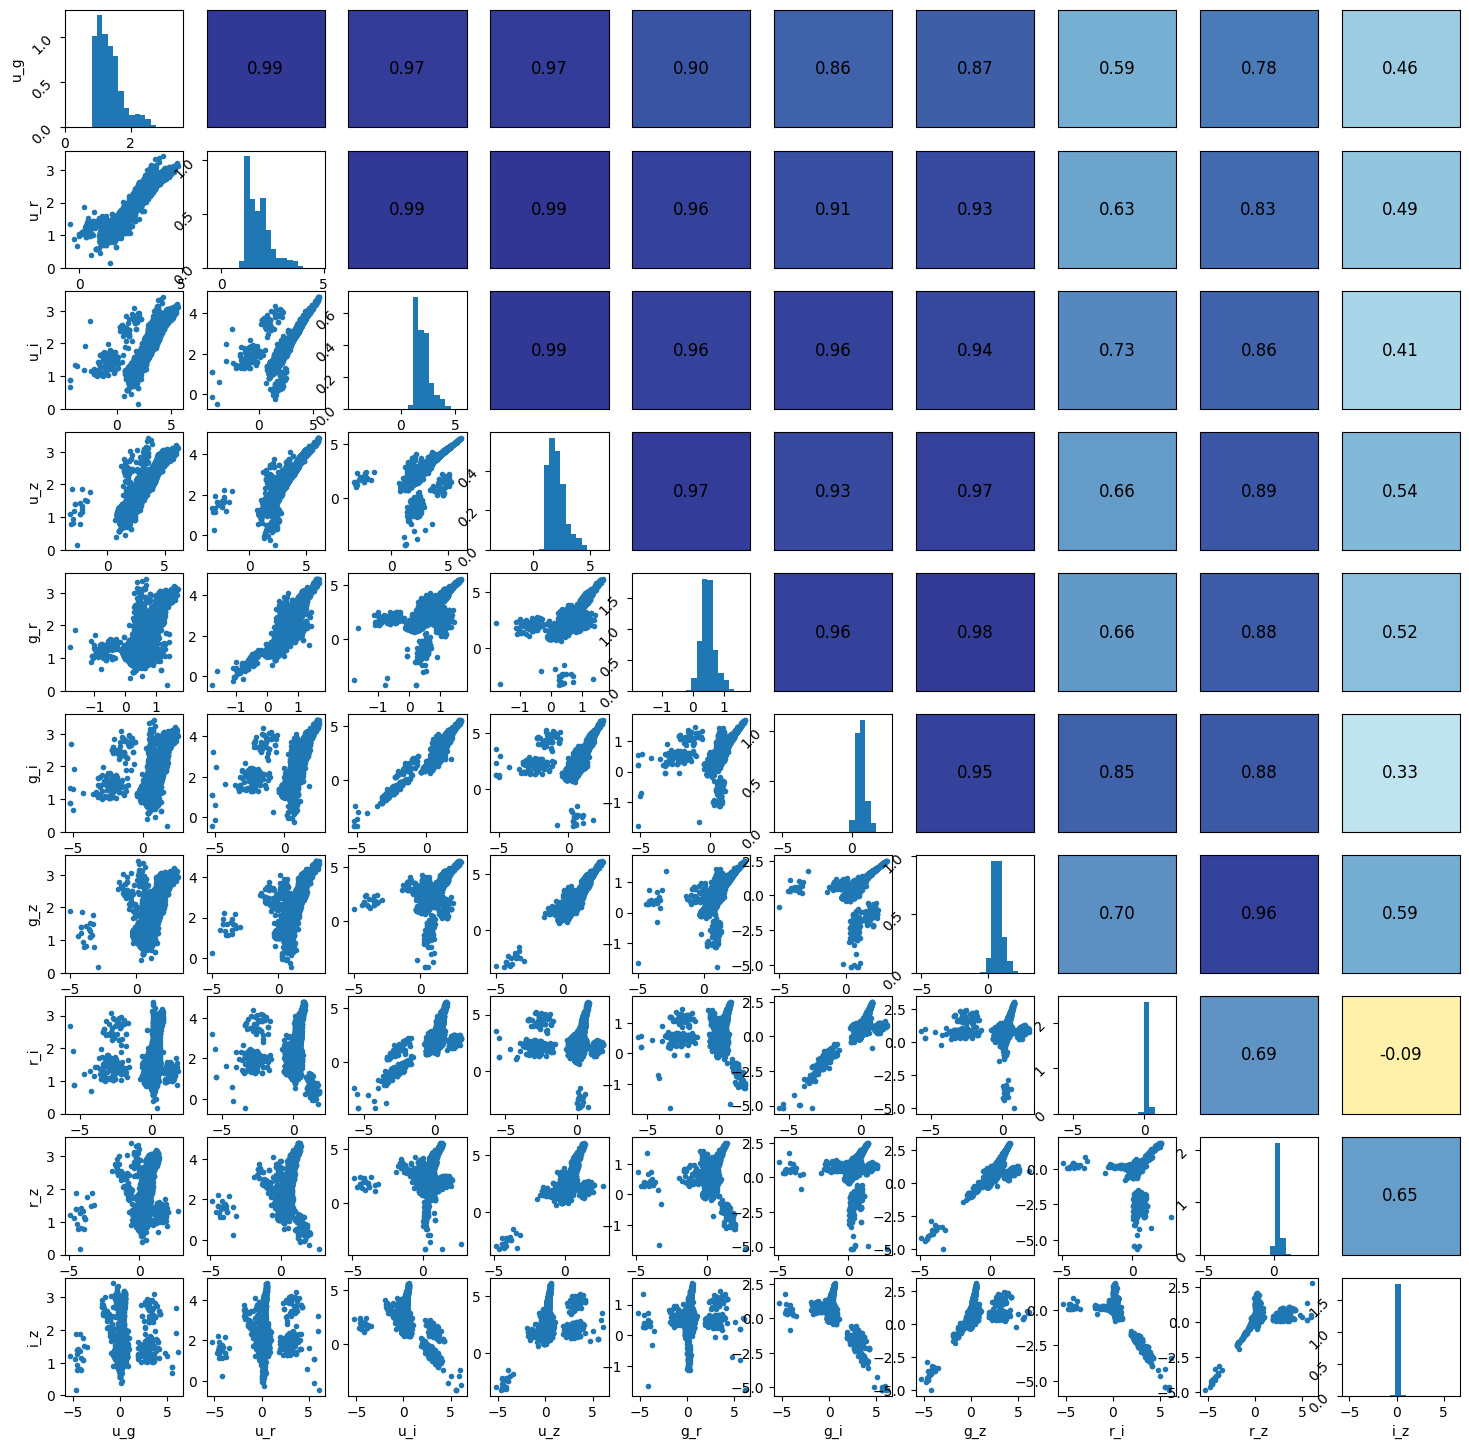

In [13]:
Xs = complete_data.drop(["feh", "teff", "logg"], axis=1)
pairplots(Xs)

## Models
We construct several different regression models to try and fit our data. Some of the models, we covered in class, where as others seemed appropriate to use for this particular regression task and insight gained from our dataset.

We perform a grid search on most of our models to pick the optimal hyperparameters that optimize our scoring metric (`neg_root_mean_squared_error`). The model performance is gauged using nested cross validation and the following API is stored for each model so that the best performant model can be trained on the entire dataset.

Model Object API
```Python
{
    "name": str,  # name of the model
    "model": object  # the estimator
    "search_grid": dict,  # parameter search grid for the model
    "features": pd.DataFrame,  # input features for the model
    "cv_score": float  # model score
}
```

In [14]:
TARGET_NAME = "teff"

features = complete_data.drop(["feh", "teff", "logg"], axis=1)
target = complete_data[TARGET_NAME]

MODELS = list()

In [15]:
# utility function to take a subset of features based on pairwise correlation
# for a certain threshold
def select_attributes(features: pd.DataFrame, threshold: float = 0.75) -> list[str]:
    column_names = features.columns
    corr_matrix = np.corrcoef(features.T)

    selected_attributes = []

    for i, col in enumerate(column_names):
        keep = True
        for selected in selected_attributes:
            j = column_names.get_loc(selected)
            # check correlation with already selected attributes
            if abs(corr_matrix[i, j]) >= threshold:
                keep = False
                break

        if keep:
            selected_attributes.append(col)

    return selected_attributes

In [16]:
# utility function to perform nested cross-validation loop and compute score
@ignore_warnings(category=ConvergenceWarning)
def nested_cv(estimator,
              param_grid: dict,
              X: pd.DataFrame,
              y: pd.Series,
              cv: int = 5,
              downsample: bool = False,
              n_samples: int = 10000) -> np.float64:

    outer_cv = KFold(n_splits=cv)
    scores = []

    for train_idx, test_idx in outer_cv.split(X, y):
        # split the data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if downsample:
            X_train, y_train = resample(X_train, y_train, n_samples=n_samples, random_state=42)

        grid_search = GridSearchCV(estimator=estimator,
                                   param_grid=param_grid,
                                   cv=cv,
                                   scoring="neg_root_mean_squared_error",
                                   verbose=2,
                                   n_jobs=-1)

        # train on data
        grid_search.fit(X_train, y_train)
        test_score = grid_search.score(X_test, y_test)
        scores.append(test_score)

    return np.mean(scores)

### MLP Regressor

We consider a Multilayer Perceptron with `relu` activations.

In [17]:
# feature selection
X, y = features[select_attributes(features)], target

# define hyperparameter grid
param_grid = {
    "mlp__max_iter": [250, 300],
    "mlp__hidden_layer_sizes": [(64, 32), (16, 8)]
}

# define fixed model parameters
model_params = {
    "random_state": 42,
    "activation": "relu",
}

# pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First scale the data
    ('mlp', MLPRegressor(**model_params))  # MLP Regressor
])

# perform a nested CV
score = nested_cv(estimator=pipeline,
                  param_grid=param_grid,
                  X=X,
                  y=y)
print("Average Score:", score)

# update models
MODELS.append({
    "name": "MLP Regressor",
    "model": pipeline,
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Average Score: -235.47506734779745


### KNN Regressor

We consider a K Nearest Neighbor regression model with the `euclidean` distance metric. Since we are using a distance metric, we standardize our data to avoid scaling biases.

In [18]:
# feature selection
X, y = features[select_attributes(features)], target

# define the parameter grid for n_neighbors
param_grid = { 'knn__n_neighbors': range(5, 50, 5) } # n_neighbors from 5 to 45 in steps of 5

# define fixed model parameters
model_params = { "metric": "euclidean", "p": 2 }

# define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First scale the data
    ('knn', KNeighborsRegressor(**model_params))  # Then apply the knn
])

# Perform a grid search with 5-fold cross-validation
score = nested_cv(estimator=pipeline,
                  param_grid=param_grid,
                  X=X,
                  y=y)
print("Average Score:", score)

# update models
MODELS.append({
    "name": "KNN Regressor",
    "model": pipeline,
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Average Score: -234.51042169302914


### Random Forest Regressor

We consider a Random Forest Regressor. Since Random Forest Regressors are robust to correlated predictors, we increase our attribute selection threshold to `0.8`.

In [19]:
# get features and targets
X, y = features[select_attributes(features, 0.8)], target

# define fixed model parameters and model
model_params = { "random_state": 42 }

rf = RandomForestRegressor(**model_params)

# define hyperparameter grid
param_grid = {
    "n_estimators": [20, 30],  # number of trees in the forest
    "max_depth": [10, 20],  # max depth of the tree
    "min_samples_split": [5, 10],  # min samples required to split an internal node
    "min_samples_leaf": [1, 2],  # min samples required to be at a leaf node
    "max_features": ["sqrt", "log2"]  # number of features to consider for best split
}

# perform nested cross validation over the defined hyperparameter space
score = nested_cv(estimator=rf,
                  param_grid=param_grid,
                  X=X,
                  y=y)
print("Average Score:", score)

# update models
MODELS.append({
    "name": "Random Forest Regressor",
    "model": rf,
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Average Score: -231.9074269664885


### Elastic Net

Elastic Net Regression is a Regularized regression technique that applies a combination of L1 (Lasso) and L2 (Ridge) regression to a standard linear regression problem. The behind this model is to allow correlated predictors to be assigned `0` weight by the regularizations.

In [20]:
# get features and targets
X, y = features[select_attributes(features, 0.9)], target

# define fixed model parameters
model_params = { "selection": "random", "random_state": 42 }

# define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First scale the data
    ('en', ElasticNet(**model_params))  # Then apply the ElasticNet Regression
])

# define hyperparameter grid
param_grid = {
    "en__alpha": np.logspace(-3, 2, 10),  # regularization strength
    "en__l1_ratio": np.linspace(0, 1, 10)  # mix between L1 (lasso) and L2 (ridge)
}

# perform nested cross validation over the defined hyperparameter space
score = nested_cv(estimator=pipeline,
                  param_grid=param_grid,
                  X=X,
                  y=y)
print("Average Score:", score)

# update models
MODELS.append({
    "name": "Elastic Net Regressor",
    "model": pipeline,
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average Score: -278.2310526798941


### Bayesian Ridge
This algorithm is similar to Linear Regression, except a prior distribution is assumed for the coefficients, and this prior distribution is used as an additive regularization parameter in terms of the probability distribution of the coefficients.

In [21]:
# get features and targets
X, y = features, target

# define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('brr', BayesianRidge())
])

# define hyperparameter grid
param_grid = {
    "brr__alpha_1": np.logspace(-7, -4, 4), # the default parameters performed best.
    "brr__alpha_2": np.logspace(-7, -4, 4),
    "brr__lambda_1": np.logspace(-7, -4, 4),
    "brr__lambda_2": np.logspace(-7, -4, 4)
}

# perform nested cross validation over the defined hyperparameter space
score = nested_cv(estimator=pipeline,
                  param_grid=param_grid,
                  X=X,
                  y=y)
print("Average Score:", score)

# update models
MODELS.append({
    "name": "Bayesian Ridge Regressor",
    "model": pipeline,
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Average Score: -278.22774554855704


### Support Vector Regressor

We considered a Support Vector Regressor. Due to the pairwise scatterplots suggesting non-linear trends, we try different kernel transforms on our SVR to correct for the non-linearity as much as possible.

> _Note_: We have to perform a lot of model selection operations for SVRs due to their high training cost
> - Since we have a large dataset (~200,000 records), we are using a kernel approximator (`Nystroem`). Otherwise, the model will create an N x N matrix, which would take up ~300GB of space.
> - Due to the size of our dataset, we downsample the training data in the cross validation loop. Since SVRs are only dependent on the support vectors, the model is robust to downsampling

In [22]:
X, y = features[select_attributes(features, 0.5)], target

# define pipeline
scaler = StandardScaler()
kernel_approximator = Nystroem()
SVR_model = SVR()

pipeline = Pipeline([
    ('scaler', scaler), # then scale the data
    ('nystroem', kernel_approximator),  # approximate the kernel
    ('SVR', SVR_model)  # apply SVMs
])

# define hyperparameter grid
param_grid = {
    'nystroem__kernel': ['linear', 'rbf', 'poly'],
    'nystroem__n_components': [50, 100, 200],
    'SVR__C': [1, 5, 10]
}

#perform nested CV
score = nested_cv(pipeline,
                  param_grid,
                  X=X,
                  y=y,
                  downsample=True)
print("Average Score:", score)

# update models
MODELS.append({
   "name": "Support Vector Regressor",
   "model": pipeline,
   "search_grid": param_grid,
   "features": X,
   "cv_score": score
})

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Average Score: -297.7956449034294


### Gradient Boosting Regressor

A gradient boosting regressor is an ensemble technique that uses a gradient descent optimization technique to improve the prediction score by adding a decision tree (one at a time) to correct the mistake of the previous trees based on the gradient.

In [23]:
X, y = features[select_attributes(features, 0.8)], target

xgb_model = xgb()

# define hyperparameter grid
param_grid = {
   'learning_rate': [0.001, 0.01, 0.1],       # Learning rate
   'n_estimators': [10, 20],                  # Number of trees
   'max_depth': [5, 10, 15]                   # max depth
}

#perform nested CV
score = nested_cv(estimator=xgb_model,
                  param_grid=param_grid,
                  X=X,
                  y=y)
print("Average Score:", score)

# update models
MODELS.append({
   "name": "Gradient Boosting Regressor",
   "model": xgb_model,
   "search_grid": param_grid,
   "features": X,
   "cv_score": score
})


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Average Score: -244.1479692710629


### Linear Regression

We consider a linear regressor with no regularization. This model has more restrictions than the other models due to its linearity conditions. We note that adding more correlated predictors does not improve the model's RMSE

In [24]:
# get features and targets
X, y = features[select_attributes(features, 0.9)], target

# define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First scale the data
    ('lr', LinearRegression())     # Then fit a linear regressor
])

param_grid = dict()

# perform nested cross validation over the defined hyperparameter space
score = nested_cv(estimator=pipeline,
                  param_grid=param_grid,
                  X=X,
                  y=y)
print("Average Score:", score)

# update models
MODELS.append({
    "name": "Linear Regressor",
    "model": pipeline,
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Average Score: -278.2009895283885


## Results and Final Model

Looking at the `RMSE` for each of the models, we can see that **Random Forest Regressor** performed the best. We will now construct a full model trained on the entire dataset and compare the predictions against the actual values.

In [25]:
# first sort the models based on their cv_score
MODELS = sorted(MODELS, key = lambda x: x["cv_score"], reverse=True)

table = []
for model in MODELS:
    table.append([model["name"], len(model["features"].columns), model["cv_score"]])

# table to show the scores of models
print(tabulate(table, headers=["Model Name", "Number of Features", "Score"]))

Model Name                     Number of Features     Score
---------------------------  --------------------  --------
Random Forest Regressor                         4  -231.907
KNN Regressor                                   3  -234.51
MLP Regressor                                   3  -235.475
Gradient Boosting Regressor                     4  -244.148
Linear Regressor                                5  -278.201
Bayesian Ridge Regressor                       10  -278.228
Elastic Net Regressor                           5  -278.231
Support Vector Regressor                        2  -297.796


In [26]:
print("Best Model:", MODELS[0]["name"])
print("Score:", MODELS[0]["cv_score"])
print()
print("Second Best Model:", MODELS[1]["name"])
print("Score:", MODELS[1]["cv_score"])

Best Model: Random Forest Regressor
Score: -231.9074269664885

Second Best Model: KNN Regressor
Score: -234.51042169302914


Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}


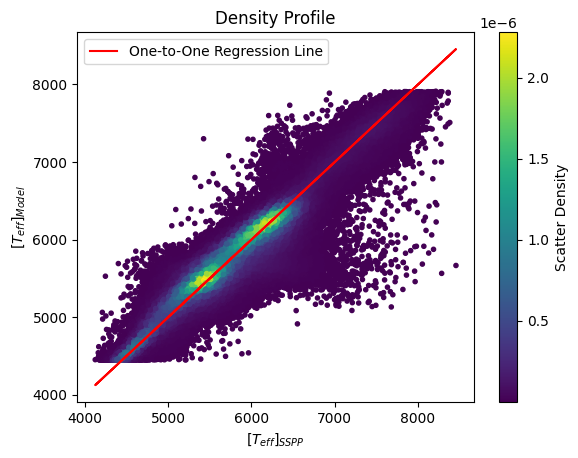

In [29]:
best_full_model = GridSearchCV(MODELS[0]["model"],
                               MODELS[0]["search_grid"],
                               scoring="neg_root_mean_squared_error",
                               n_jobs=-1,
                               verbose=2)

best_full_model.fit(MODELS[0]["features"], target)

print(best_full_model.best_params_)

predicted = best_full_model.predict(MODELS[0]["features"])

tp = np.vstack((target, predicted))
z = sts.gaussian_kde(tp)(tp)

plt.scatter(target, predicted, c=z, marker=".")
plt.plot(target, target, 'r-', label="One-to-One Regression Line")
plt.xlabel(r'$[T_{eff}]_{SSPP}$')
plt.ylabel(r'$[T_{eff}]_{Model}$')
plt.colorbar(label="Scatter Density")
plt.legend(loc="best")
plt.title("Density Profile")
plt.plot()

final_name = "finalized_model.sav"
pickle.dump(best_full_model, open(final_name, "wb"))